**1. Configuração do ambiente e importação de bibliotecas**

In [178]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [179]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn import metrics
import numpy as np
from sklearn.datasets import make_blobs
import time
from matplotlib import pyplot as plt

In [180]:
#Importando dados
df = pd.read_excel('/content/drive/MyDrive/SANTANDER-MACHINE-LEARNING/Online Retail.xlsx')

In [181]:
df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France


**2. Tratamento da base**

A seguir será colocado o tratamento prévio da base, antes de realizar a modelagem.

In [182]:
#Filtra o DataFrame para incluir apenas linhas onde a quantidade ('Quantity') é maior ou igual a zero.
df = df[df['Quantity'] >= 0]

#Filtra novamente o DataFrame para incluir apenas linhas onde o preço unitário ('UnitPrice') é maior ou igual a zero.
df = df[df['UnitPrice'] >= 0]

#Filtra mais uma vez o DataFrame para incluir apenas linhas onde o preço unitário ('UnitPrice') é menor ou igual a 1000.
df = df[df['UnitPrice'] <= 1000]

# Retirando as linhas com valores faltantes da base
df_na = df.dropna(subset=['CustomerID'])

**3. Manipulação dos dados**

In [183]:
#Novo atributo que representa a quantia monerátia na operação 'Amount'
df_na['Amount'] = df_na['Quantity']*df_na['UnitPrice']

#Cria um novo DataFrame 'df_total' agrupando os dados por 'CustomerID' e calculando a soma da coluna 'Amount' para cada cliente.
df_total = pd.DataFrame(df_na.groupby('CustomerID')['Amount'].sum())
df_total = df_total.rename(columns={'Amount': 'Valor Total'})
df_total = df_total.reset_index()

#Cria um novo DataFrame 'df_freq' agrupando os dados por 'CustomerID' e contando o número único de datas de faturas ('InvoiceDate') para cada cliente.
df_freq = pd.DataFrame(df_na.groupby('CustomerID')['InvoiceDate'].nunique())
df_freq = df_freq.rename(columns={'InvoiceDate': 'Frequencia'})
df_freq = df_freq.reset_index()

#Realiza uma operação de merge (junção) entre os DataFrames 'df_total' e 'df_freq' usando 'CustomerID' como chave de junção.
df_uni=pd.merge(df_total, df_freq)

df_uni['Valor/Freq']=df_uni['Valor Total']/df_uni['Frequencia']

df_uni

<ipython-input-183-d6303b08a6ba>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_na['Amount'] = df_na['Quantity']*df_na['UnitPrice']


,CustomerID,Valor Total,Frequencia,Valor/Freq
0,12346.0,77183.60,1,77183.600000
1,12347.0,4310.00,7,615.714286
2,12348.0,1797.24,4,449.310000
3,12349.0,1757.55,1,1757.550000
4,12350.0,334.40,1,334.400000
...,...,...,...,...
4333,18280.0,180.60,1,180.600000
4334,18281.0,80.82,1,80.820000
4335,18282.0,178.05,2,89.025000
4336,18283.0,2094.88,16,130.930000


**4. DBSCAN**

**4.1 Teste inicial com valores defaults**

In [184]:
df_uni_def = df_uni.copy()
clustering = DBSCAN().fit(df_uni_def)  # usando valores default
df_uni_def['cluster'] = clustering.labels_
df_uni_def

,CustomerID,Valor Total,Frequencia,Valor/Freq,cluster
0,12346.0,77183.60,1,77183.600000,-1
1,12347.0,4310.00,7,615.714286,-1
2,12348.0,1797.24,4,449.310000,-1
3,12349.0,1757.55,1,1757.550000,-1
4,12350.0,334.40,1,334.400000,-1
...,...,...,...,...,...
4333,18280.0,180.60,1,180.600000,-1
4334,18281.0,80.82,1,80.820000,-1
4335,18282.0,178.05,2,89.025000,-1
4336,18283.0,2094.88,16,130.930000,-1


<Axes: xlabel='Frequencia', ylabel='Valor Total'>

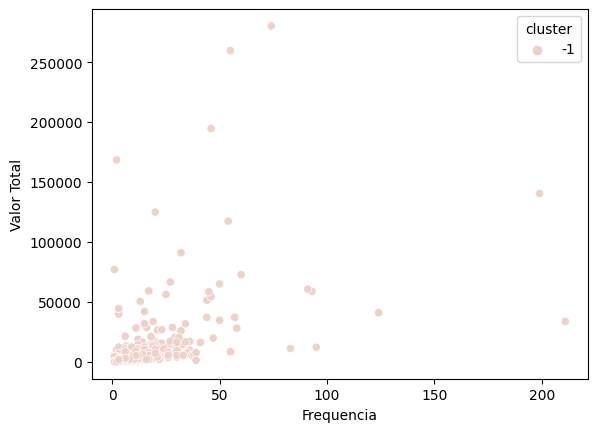

In [195]:
sns.scatterplot(data=df_uni_def, x='Frequencia', y='Valor Total',hue='cluster')

Conforme visto no gráfico, não houve divisão de dados, sendo estes agrupados em apenas um cluster, sendo necessário ajustar os parâmetros **eps** (Raio máximo entre dois pontos) e **minPts** (Número mínimo de pontos em uma região)

**4.2 Estimativa de valores ideais para os parâmetros eps e minPts**

- Com algoritmo de vizinhança

In [239]:
df_neib = df_uni.copy()
neighbors = NearestNeighbors(n_neighbors=15)
neighbors_fit = neighbors.fit(df_neib)
distances, indices = neighbors_fit.kneighbors(df_neib)

pd.DataFrame(np.mean(distances,axis=0))

,0
0,0.000000
1,183.449278
2,264.665370
3,333.101812
4,373.127642
5,409.146756
6,438.786906
7,478.101556
8,511.775362
9,535.581344


In [240]:
t1 = time.perf_counter()
clustering = DBSCAN(eps=600, min_samples=10).fit(df_neib)
t2 = time.perf_counter()
print('Tempo:',t2-t1)
df_neib['cluster'] = clustering.labels_

Tempo: 0.14989587299896812


<Axes: xlabel='Frequencia', ylabel='Valor Total'>

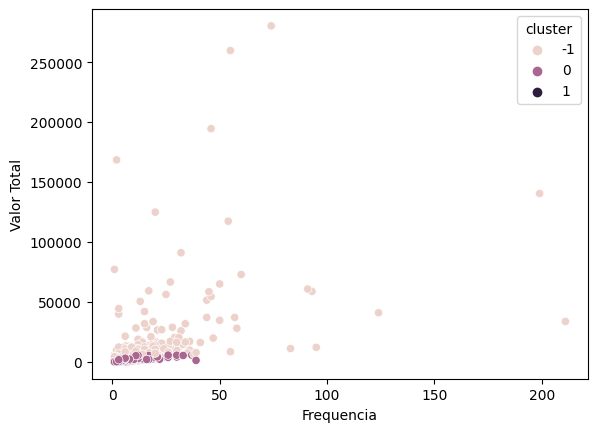

In [241]:
sns.scatterplot(data=df_neib, x='Frequencia', y='Valor Total',hue='cluster')

- Identificação de outliers

In [242]:
df_neib['outlier'] = 0
condition  = (df_neib['cluster'] == -1 )
df_neib.loc[condition, 'outlier'] = 1
df_neib

,CustomerID,Valor Total,Frequencia,Valor/Freq,cluster,outlier
0,12346.0,77183.60,1,77183.600000,-1,1
1,12347.0,4310.00,7,615.714286,0,0
2,12348.0,1797.24,4,449.310000,0,0
3,12349.0,1757.55,1,1757.550000,0,0
4,12350.0,334.40,1,334.400000,0,0
...,...,...,...,...,...,...
4333,18280.0,180.60,1,180.600000,0,0
4334,18281.0,80.82,1,80.820000,0,0
4335,18282.0,178.05,2,89.025000,0,0
4336,18283.0,2094.88,16,130.930000,0,0


<Axes: xlabel='Frequencia', ylabel='Valor Total'>

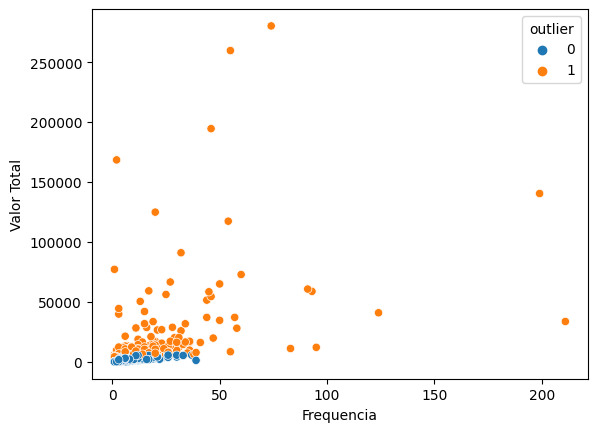

In [243]:
sns.scatterplot(data=df_neib, x='Frequencia', y='Valor Total',hue='outlier')

**4.3 Clusters com valores dados pelo algoritmo de vizinhança**

In [244]:
df_clusters = df_neib.loc[df_neib['cluster'] != -1]

<Axes: xlabel='Frequencia', ylabel='Valor Total'>

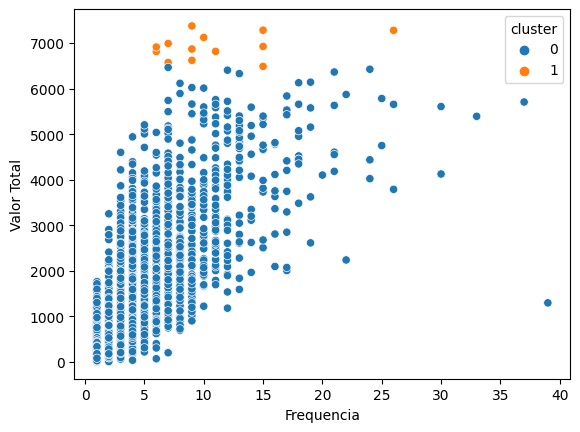

In [245]:
sns.scatterplot(data=df_clusters, x='Frequencia', y='Valor Total',hue='cluster')

**4.4 Tempo usando o kd_tree para acelerar o DBSCAN**

In [247]:
df_kd = df_uni.copy()
t1 = time.perf_counter()
clustering = DBSCAN(eps=600, min_samples=10, algorithm='kd_tree').fit(df_kd)
t2 = time.perf_counter()
print('Tempo:',t2-t1)

Tempo: 0.0925901390000945


<Axes: xlabel='Frequencia', ylabel='Valor Total'>

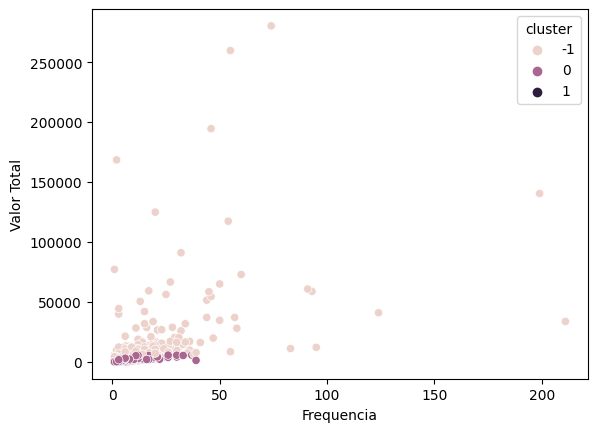

In [248]:
df_kd['cluster'] = clustering.labels_
sns.scatterplot(data=df_kd, x='Frequencia', y='Valor Total',hue='cluster')

<Axes: xlabel='Frequencia', ylabel='Valor Total'>

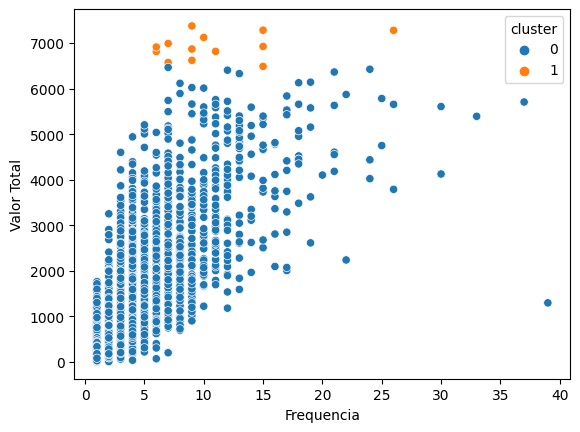

In [249]:
df_kd['outlier'] = 0
condition  = (df_kd['cluster'] == -1 )
df_kd.loc[condition, 'outlier'] = 1

df_clusters_kd = df_kd.loc[df_kd['cluster'] != -1]
sns.scatterplot(data=df_clusters_kd, x='Frequencia', y='Valor Total',hue='cluster')